# REINFORCE (Ronald J Williams, 1992)

REINFORCE is a policy gradient method that optimizes expected $\gamma$ - discounted return $R$:


$$\theta^*=\arg\max_{\theta}(\mathbb{E}_{\pi_{\theta}}[R])$$

To find the maximum of $\theta$ we can use gradient **ascent**, but only after making the expectation differentiable. Applying the log trick gives us:

$$
\nabla_{\theta} \mathbb{E}_{\pi_{\theta}}(R) = \mathbb{E}[R*\nabla_{\theta}{log(\pi_{\theta})}]
$$

Additionally a baseline constant $b=\mathbb{E}[R]$ is used to reduce variance of the gradient. It can be shown that:

$$
\nabla_{\theta}\mathbb{E_{\pi_{\theta}}}[b] = 0 \implies \mathbb{E}[R*\nabla_{\theta}{log(\pi_{\theta})}] = \mathbb{E}[(R-b)*\nabla_{\theta}{log(\pi_{\theta})}]
$$

This gradient can be sampled from the current suboptimal policy.
In this notebook we use Monte Carlo episode samples which are unbiased estimates of $R$.
After each episode $\theta$ is updated towards the gradient multiplied by a learning rate $\alpha$.

$$ \theta = \theta + \alpha * R * \nabla_{\theta}{log(\pi_{\theta})}$$

To trick torch into thinking that it's doing gradient **descent** we introduce a "loss" function which is the negative of $R * \nabla_{\theta}{log(\pi_{\theta})}$

Learning rate is decayed exponentially with the number of episodes to improve convergence of the policy. $\alpha_{e+1}=\alpha_e*\lambda$



In [23]:
import gym
import numpy as np
import torch as th
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
class PolicyNetwork(th.nn.Module):
    def __init__(self, state_size, actions_size, hidden_size):
        super().__init__()
        self.nn = th.nn.Sequential(
            th.nn.Linear(state_size, out_features=hidden_size),
            th.nn.SiLU(),
            th.nn.Linear(hidden_size, actions_size),
            th.nn.Softmax(-1),
        )
        self.actions_size = actions_size


    def forward(self, state):
        return self.nn(state)

    def get_action(self, state):
        x = th.tensor(state)
        out = self.forward(x)
        dist = th.distributions.Categorical(out)
        action = dist.sample().item()
        return action, out[action].log(), out

PolicyNetwork(2, 2, 4).get_action([1., 2])

(1,
 tensor(-0.5610, grad_fn=<LogBackward0>),
 tensor([0.4293, 0.5707], grad_fn=<SoftmaxBackward0>))

In [32]:
def policy_objective(rewards, log_probs, gamma, centered=False):
    returns = []
    for i in range(len(rewards) - 1, -1, -1):
        rwd = rewards[i]
        if len(returns) > 0:
            rwd += gamma * returns[-1]
        returns.append(rwd)

    returns = th.tensor(list(reversed(returns)))
    if centered:
        returns = returns - th.mean(returns)

    obj = returns * th.stack(log_probs)
    loss = -obj.sum()
    return loss, returns

policy_objective([1] * 2, [th.tensor(-1)] * 2, 0.9, centered=False)

(tensor(2.9000), tensor([1.9000, 1.0000]))

/Users/vslaykovsky/simplementations/venv/lib/python3.9/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


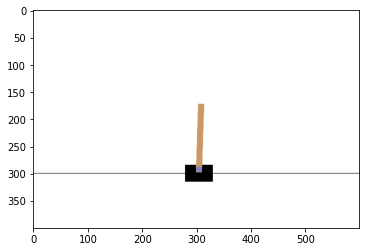

In [33]:
with gym.make('CartPole-v0', new_step_api=True, render_mode="rgb_array") as env:
    env.reset()
    plt.imshow(env.render()[0])

## Train

/Users/vslaykovsky/simplementations/venv/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/vslaykovsky/simplementations/venv/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/vslaykovsky/simplementations/venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/Users/vslaykovsky/simplementations/venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:574: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


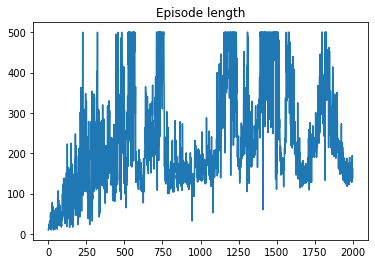

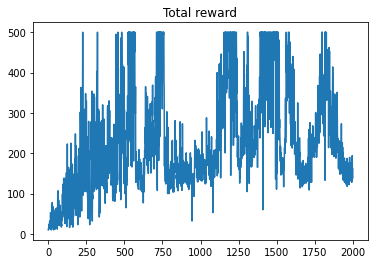

In [34]:
def train(max_episodes, gamma=0.9, capacity=128, lr=3e-4, lamb=0.999):
    with gym.make('CartPole-v1', new_step_api=False, render_mode=None) as env:
        model = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, capacity)
        model.train()
        opt = th.optim.SGD(params=model.parameters(), lr=lr)
        scheduler = th.optim.lr_scheduler.ExponentialLR(opt, gamma=lamb)
        episode_lengths = []
        total_rewards = []
        progress = tqdm(range(max_episodes))
        for episode in progress:
            state = env.reset()
            rewards = []
            logprobs = []
            actions = []
            while True:
                action, logprob = model.get_action(state)[:2]
                state, reward, done, _ = env.step(action)
                rewards.append(reward)
                actions.append(action)
                logprobs.append(logprob)
                if done:
                    loss, _ = policy_objective(rewards, logprobs, gamma, centered=True)
                    opt.zero_grad()
                    loss.backward()
                    opt.step()
                    scheduler.step(episode)
                    episode_lengths.append(len(rewards))
                    total_rewards.append(np.sum(rewards))
                    progress.set_description(desc=f'LR: {scheduler.get_lr()[0]:.05f} Episode len:{np.mean(episode_lengths[-10:])}, total reward:{np.mean(total_rewards[-10:]):.02f}')
                    break
        return model, episode_lengths, total_rewards

model, episode_lengths, total_rewards = train(max_episodes=2000, gamma=0.9, capacity=256, lr=1e-3)
plt.figure()
plt.plot(episode_lengths)
plt.title('Episode length')
plt.figure()
plt.title('Total reward')
plt.plot(total_rewards)

## Render

In [6]:
with gym.make('CartPole-v1', new_step_api=False, render_mode='human') as env:
    for i in range(2):
        state = env.reset()
        for s in range(1000):
            action = model.get_action(state)[0]
            state, reward, done, _ = env.step(action)
            if done:
                break